In [1]:
import networkx as nx
from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit import Parameter
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram
from BA import BA
from PSO import PSO
from ACO import ACO
from ABC import ABC
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi 
import time
import qiskit.quantum_info as qi

In [2]:
'''
Class MaxCutSolver.
A class that is commited to solve a max cut instance problem.
'''
class MaxCutSolver():
        
    '''
    The constructor of the class.
    Params: 
        - graph: The graph of which we want the max cut.
        - num_qubits: The number of qubits needed.
        - backend: The back for running the experiments.
        - p (optinal): The p value for the QAOA
    '''
    def __init__(self, graph, num_qubits, backend, p = 1):
        self.graph = graph
        self.numqubits = num_qubits
        self.circuit = QuantumCircuit(num_qubits)
        self.backend = backend
        self.p = p
        for i in range(0,  self.numqubits):
            self.circuit.h(i)
        gamma = [Parameter("gamma" + str(i)) for i in range(0,p)]
        beta = [Parameter("beta" + str(i)) for i in range(0,p)]
        for j in range(0, p):
            for nodes in list(graph.edges()): 
                self.circuit.rzz(2 * gamma[j], nodes[0], nodes[1])
            for i in range(0,  self.numqubits):
                self.circuit.rx(2 * beta[j], i)

    '''
    Method to get the cost of a cut.
    Params: 
        - bitstring: The cut of the graph.
    Returns:
        - float: the cost of the cut
    '''
    def get_cost_graph(self, bitstring):
        cost = 0
        for i, j in self.graph.edges():
            if bitstring[i] != bitstring[j]:
                cost -= 1
        return cost

    '''
    Method that applies a measurement and executes the class circuit 
    using the parameters passed as a parameter.
    Params: 
        - params: a list that contains the parameters
        for the circuit.
    Returns:
        - dict: a python dict that contains the counts of 
        the execution.
    '''
    def output_circuit(self, params):
        backend = Aer.get_backend(self.backend)
        backend.shots = 1000
        qc_res = self.circuit.copy()
        qc_res = qc_res.bind_parameters(params)
        if (self.backend == 'statevector_simulator'):
            result = qi.Statevector.from_instruction(qc_res).probabilities_dict()
            return result
        else:
            qc_res.measure_all()
            counts = backend.run(qc_res).result().get_counts()
            return counts

    '''
    Method that gets the average value of the execution
    of the class circuit.
    Params: 
        - params: a list that contains the parameters
        for the circuit.
    Returns:
        - float: the average value of the excution.
    '''
    def get_expectation(self, params):
        backend = Aer.get_backend(self.backend)
        qc = self.circuit.copy()
        qc = qc.bind_parameters(params)

        if (self.backend == 'qasm_simulator'):
            qc.measure_all()
            counts = execute(qc, nshots=1000, backend=backend).result().get_counts()
        else:
            counts = qi.Statevector.from_instruction(qc).probabilities_dict()
        avg = 0
        sum_count = 0
        for bitstring, count in counts.items():
            obj = self.get_cost_graph(bitstring)
            avg += obj * count
            sum_count += count
        return avg/sum_count
        
    '''
    Method that gets the optimal values for the parameters
    of the class circuit using the COBYLA optimizer.
    Params: 
        - init_point: the initial point for the cobyla
        optimizer.
    Returns:
        - list: a python list that contains the optimal values.
    '''
    def optimize_classic(self, method, init_point = None):
        #def first_guess_linear(n):
        #    theta = [random.uniform(0, pi) for _ in range(0,n)] + [random.uniform(0, 2*pi) for _ in range(0,n)]
        #    return (theta)
        def first_guess_linear(p,m1=0.5,m2=0.5):
            theta=np.zeros([2*p])
            for i in range(2*p):
                if i % 2 ==0:
                    theta[i]=m1*(i+1)/(2*p)
                else:
                    theta[i]=m2*(2*p-i)/(2*p)
            return(theta)
        def x_ungerade(i,p):# for odd angles (gamma's)
            return (i+0.5)/p
            #return (i+0.25)/(p-0.75)   # unclear what is the best choice for x_i
        def x_gerade(i,p): # for even angles (beta's)
            return (i+0.5)/p
            #return i/p  # unclear what is the best choice for x_i
        def extrapolate(theta):
            p=len(theta)//2+1
            if p<=2: # Extrapolation only makes sense for p>2. Otherwise, take linear guess
                return(first_guess_linear(p))
            else:
                theta2=np.zeros([2*p])
                for i in range(2*p):
                    if i % 2 == 0:
                        x_func = x_ungerade
                        j=0
                    else:
                        x_func = x_gerade
                        j=1
                    x=x_func(i//2,p)
                    while x_func(j//2 +1,p-1)<x:
                        j+=2
                    while j//2>p-3:
                        j-=2
                    x1=x_func(j//2,p-1)
                    x2=x_func(j//2+1,p-1)
                    y1=theta[j]
                    y2=theta[j+2]
                    theta2[i]=((y1-y2)*x+x1*y2-y1*x2)/(x1-x2)
                    i+=1
            return(theta2)
        expectation = self.get_expectation
        if(not init_point):
            theta=[]
            for _ in range(1,self.p+1):
                theta = extrapolate(theta)
            init_point = theta
            print(init_point)
        res = minimize(expectation, init_point, method=method)
        return res

    '''
    Method that gets the optimal values for the parameters
    of the class circuit using the PSO optimizer.
    Params: 
        - interval: the interval to initialize each coordinate of the initial point
        of the particles.
        - dimentions: the number of parameters for the optimizer to optimize.
    Returns:
        - list: a python list that contains the optimal values.
    '''
    def optimize_swarm(self, interval):
        expectation = self.get_expectation
        pso =  PSO(num_particles=20, num_params=self.p*2, interval=interval, function=expectation)
        return pso.run(w=0.4,c1=0.1,c2=0.1, num_iterations=50)


    '''
    Method that gets the optimal values for the parameters
    of the class circuit using the PSO optimizer.
    Params: 
        - interval: the interval to initialize each coordinate of the initial point
        of the particles.
        - dimentions: the number of parameters for the optimizer to optimize.
    Returns:
        - list: a python list that contains the optimal values.
    '''
    def optimize_bees(self, interval):
        expectation = self.get_expectation
        abc =  ABC(dimention=self.p*2, num_points=30, bonds=interval, numlookers=15, fx=expectation)
        return abc.run(num_iterations=50, limit=15, a=pi)


    '''
    Method that gets the optimal values for the parameters
    of the class circuit using the BA optimizer.
    Params: 
        - interval: the interval to initialize each coordinate of the initial point
        of the bats.
        - dimentions: the number of parameters for the optimizer to optimize.
    Returns:
        - list: a python list that contains the optimal values.
    '''
    def optimize_bats(self, interval):
        expectation = self.get_expectation
        ba = BA(number_of_bats=20, num_dimentions=self.p*2, interval=interval, number_of_iterations=50, alfa= 0.9, gamma=0.9)
        return ba.run(expectation)

    '''
    Method that gets the optimal values for the parameters
    of the class circuit using the ACO optimizer.
    Params: 
        - interval: the interval to initialize each coordinate of the initial point
        of the ants.
        - dimentions: the number of parameters for the optimizer to optimize.
    Returns:
        - list: a python list that contains the optimal values.
    '''
    def optimize_ants(self, interval):
        expectation = self.get_expectation
        aco = ACO(num_params=self.p*2,discrete_points=200,interval=interval,
        number_ants=20,q=0.5, evaporation_rate=0.9, num_iterations = 10)
        return aco.run(expectation)
        

In [20]:
def get_cost_graph(bitstring, graph):
    cost = 0
    for i, j in graph.edges():
        if bitstring[i] != bitstring[j]:
            cost += 1
    return cost

def get_objective(number_nodes):
    G = nx.generators.classic.complete_graph(number_nodes)
    #G = nx.generators.erdos_renyi_graph(number_nodes, 0.8)
    nx.draw(G, with_labels=True, alpha=0.8, node_size=500)
    best_candidate = ""
    best_cost = 0
    for i in range(0,2**number_nodes):
        candidate = "0"*(number_nodes-len(bin(i).replace("0b", "")))+bin(i).replace("0b", "")
        candidate_cost = get_cost_graph(candidate, G)
        if(candidate_cost > best_cost):
            best_candidate = candidate
            best_cost = candidate_cost
    print(best_candidate, best_cost)
    return G

In [4]:
def test_n_nodes(number_nodes,objective, G):
    #G = nx.generators.classic.complete_graph(number_nodes)
    gradient_values_nm_p = list()
    gradient_values_cobyla_p = list()
    gradient_values_slsqp_p = list()
    swarm_values_p = list()
    bats_values_p = list()
    ants_values_p = list()
    bees_values_p = list()
    gradient_values_nm = list()
    gradient_values_cobyla = list()
    gradient_values_slsqp = list()
    swarm_values = list()
    bats_values = list()
    ants_values = list()
    bees_values = list()
    gradient_time_nm = list()
    gradient_time_cobyla = list()
    gradient_time_slsqp = list()
    swarm_time = list()
    bats_time = list()
    ants_time = list()
    bees_time = list()
    gradient_iterations_nm = list()
    gradient_iterations_cobyla = list()
    gradient_iterations_slsqp = list()
    swarm_iterations = list()
    bats_iterations = list()
    ants_iterations = list()
    bees_iterations = list()
    p_range = 8
    for i in range(1, p_range):
        myanzats = MaxCutSolver(graph=G, num_qubits=number_nodes, backend='qasm_simulator', p=i)
        start_time = time.time()
        opt_gradient_nm = myanzats.optimize_classic(method='Nelder-Mead')
        gradient_time_nm.append(time.time() - start_time)
        start_time = time.time()
        opt_gradient_cobyla = myanzats.optimize_classic(method='COBYLA').x
        gradient_time_cobyla.append(time.time() - start_time)
        start_time = time.time()
        opt_gradient_slsqp = myanzats.optimize_classic(method='SLSQP')
        gradient_time_slsqp.append(time.time() - start_time)
        start_time = time.time()
        opt_bats = myanzats.optimize_bats([0,pi])
        bats_time.append(time.time() - start_time )
        start_time = time.time()
        opt_ants,iter_ants = myanzats.optimize_ants([-5,5])
        ants_time.append(time.time() - start_time)
        start_time = time.time()
        opt_swarm = myanzats.optimize_swarm([-5,5])
        swarm_time.append(time.time() - start_time)
        start_time = time.time()
        opt_bee = myanzats.optimize_bees([0,2*pi])
        bees_time.append(time.time() - start_time)


        gradient_iterations_nm.append(opt_gradient_nm.nit)
        gradient_iterations_slsqp.append(opt_gradient_slsqp.nit)
        opt_gradient_nm = myanzats.optimize_classic(method='Nelder-Mead').x
        opt_gradient_slsqp = myanzats.optimize_classic(method='SLSQP').x
        
        swarm_iterations.append(100)
        bats_iterations.append(50)
        ants_iterations.append(iter_ants)
        bees_iterations.append(10)
        mean_gradient_p_nm = 0
        mean_gradient_p_cobyla = 0
        mean_gradient_p_slsqp = 0
        mean_ants_p = 0
        mean_bats_p = 0
        mean_swarm_p = 0
        mean_bees_p = 0
        mean_gradient_nm = 0
        mean_gradient_cobyla = 0
        mean_gradient_slsqp = 0
        mean_ants = 0
        mean_bats = 0
        mean_swarm = 0
        mean_bees = 0

        for i in range(0,30):

            gradient_dict_nm = myanzats.output_circuit(opt_gradient_nm)
            gradient_dict_cobyla = myanzats.output_circuit(opt_gradient_cobyla)
            gradient_dict_slsqp = myanzats.output_circuit(opt_gradient_slsqp)
            swarm_dict = myanzats.output_circuit(opt_swarm)
            bats_dict = myanzats.output_circuit(opt_bats)
            ants_dict = myanzats.output_circuit(opt_ants)
            bees_dict = myanzats.output_circuit(opt_bee)

            mean_bats_p = 0 if not objective in bats_dict else bats_dict[objective]/max(bats_dict.values())
            mean_swarm_p = 0 if not objective in swarm_dict else swarm_dict[objective]/max(swarm_dict.values())
            mean_gradient_p_nm = 0 if not objective in gradient_dict_nm else gradient_dict_nm[objective]/max(gradient_dict_nm.values())
            mean_gradient_p_cobyla = 0 if not objective in gradient_dict_cobyla else gradient_dict_cobyla[objective]/max(gradient_dict_cobyla.values())
            mean_gradient_p_slsqp = 0 if not objective in gradient_dict_slsqp else gradient_dict_slsqp[objective]/max(gradient_dict_slsqp.values())
            mean_ants_p = 0 if not objective in ants_dict else ants_dict[objective]/max(ants_dict.values())
            mean_bees_p = 0 if not objective in bees_dict else bees_dict[objective]/max(bees_dict.values())
            

            mean_gradient_nm += 0 if not objective in gradient_dict_nm else gradient_dict_nm[objective]/1000  
            mean_gradient_cobyla += 0 if not objective in gradient_dict_cobyla else gradient_dict_cobyla[objective]/1000
            mean_gradient_slsqp += 0 if not objective in gradient_dict_slsqp else gradient_dict_slsqp[objective]/1000
            mean_swarm += 0 if not objective in swarm_dict else swarm_dict[objective]/1000 
            mean_bats += 0 if not objective in bats_dict else bats_dict[objective]/1000 
            mean_ants += 0 if not objective in ants_dict else ants_dict[objective]/1000
            mean_bees += 0 if not objective in bees_dict else bees_dict[objective]/1000


        bats_values.append(mean_bats/30)
        swarm_values.append(mean_swarm/30)
        gradient_values_nm.append(mean_gradient_nm/30)
        gradient_values_cobyla.append(mean_gradient_cobyla/30)
        gradient_values_slsqp.append(mean_gradient_slsqp/30)
        ants_values.append(mean_ants/30)
        bees_values.append(mean_bees/30)
        bats_values_p.append(mean_bats_p/30)
        swarm_values_p.append(mean_swarm_p/30)
        gradient_values_nm_p.append(mean_gradient_p_nm/30)
        gradient_values_cobyla_p.append(mean_gradient_p_cobyla/30)
        gradient_values_slsqp_p.append(mean_gradient_p_slsqp/30)
        ants_values_p.append(mean_ants_p/30)
        bees_values_p.append(mean_bees_p/30)
    
    print("\n")
    print("\n")
    print("\n")
    print("\n")

    print("gradient_values_nm_p="+str(gradient_values_nm_p))
    print("gradient_values_cobyla_p="+str(gradient_values_cobyla_p))
    print("gradient_values_slsqp_p="+str(gradient_values_slsqp_p))
    print("swarm_values_p"+str(swarm_values_p))
    print("bats_values_p="+str(bats_values_p))
    print("ants_values_p="+str(ants_values_p))
    print("bees_values_p="+str(bees_values_p))


    plt.plot(list(range(1,p_range)), gradient_values_nm_p, '-o')
    plt.plot(list(range(1,p_range)), gradient_values_cobyla_p, '-o')
    plt.plot(list(range(1,p_range)), gradient_values_slsqp_p, '-o')
    plt.plot(list(range(1,p_range)), swarm_values_p, '-o')
    plt.plot(list(range(1,p_range)), bats_values_p, '-o')
    plt.plot(list(range(1,p_range)), ants_values_p, '-o')
    plt.plot(list(range(1,p_range)), bees_values_p, '-o')
    plt.legend(["Nelder-Mead", "COBYLA","SLSQP","PSO", "BA", "ACO", "ABC"])
    plt.title("P value vs approximation ratio for 1000 shots on QASM simulator")
    plt.xlabel('p-value', fontsize=18)
    plt.ylabel('approximation ratio', fontsize=16)
    plt.show()

    print("gradient_values_nm="+str(gradient_values_nm))
    print("gradient_values_cobyla="+str(gradient_values_cobyla))
    print("gradient_values_slsqp="+str(gradient_values_slsqp))
    print("swarm_values="+str(swarm_values))
    print("bats_values="+str(bats_values))
    print("ants_values="+str(ants_values))
    print("bees_values="+str(bees_values))

    plt.plot(list(range(1,p_range)), gradient_values_nm, '-o')
    plt.plot(list(range(1,p_range)), gradient_values_cobyla, '-o')
    plt.plot(list(range(1,p_range)), gradient_values_slsqp, '-o')
    plt.plot(list(range(1,p_range)), swarm_values, '-o')
    plt.plot(list(range(1,p_range)), bats_values, '-o')
    plt.plot(list(range(1,p_range)), ants_values, '-o')
    plt.plot(list(range(1,p_range)), bees_values, '-o')
    plt.legend(["Nelder-Mead", "COBYLA","SLSQP","PSO", "BA", "ACO", "ABC"])
    plt.title("P value vs ground state probability for 1000 shots on QASM simulator")
    plt.xlabel('p-value', fontsize=18)
    plt.ylabel('probability', fontsize=16)
    plt.show()

    print( "gradient_time_nm=" +str(gradient_time_nm))
    print( "gradient_time_cobyla=" +str(gradient_time_cobyla))
    print( "gradient_time_slsqp=" +str(gradient_time_slsqp))
    print( "swarm_time=" +str(swarm_time))
    print( "bats_time=" +str(bats_time))
    print( "ants_time=" +str(ants_time))
    print( "bees_time=" +str(bees_time))

    plt.plot(list(range(1,p_range)), gradient_time_nm, '-o')
    plt.plot(list(range(1,p_range)), gradient_time_cobyla, '-o')
    plt.plot(list(range(1,p_range)), gradient_time_slsqp, '-o')
    plt.plot(list(range(1,p_range)), swarm_time, '-o')
    plt.plot(list(range(1,p_range)), bats_time, '-o')
    plt.plot(list(range(1,p_range)), ants_time, '-o')
    plt.plot(list(range(1,p_range)), bees_time, '-o')
    plt.legend(["Nelder-Mead", "COBYLA","SLSQP","PSO", "BA", "ACO", "ABC"])
    plt.title("P value vs execution time for 1000 shots on QASM simulator")
    plt.xlabel('p-value', fontsize=18)
    plt.ylabel('execution time', fontsize=16)
    plt.show()

# 4 nodes graph

0011 4


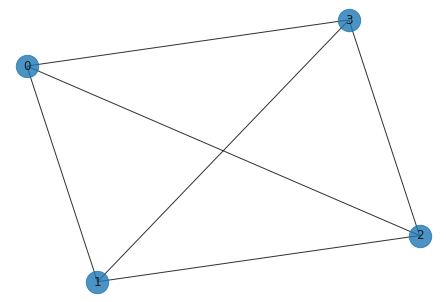

In [15]:
G = get_objective(4)

[0.25 0.25]
[0.25 0.25]
[0.25 0.25]
iteration 0 with cost of -3.2763671875
[0.25 0.25]
[0.25 0.25]
[0.125 0.375 0.375 0.125]
[0.125 0.375 0.375 0.125]
[0.125 0.375 0.375 0.125]
iteration 0 with cost of -3.74609375
[0.125 0.375 0.375 0.125]
[0.125 0.375 0.375 0.125]
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
iteration 0 with cost of -3.158203125
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
iteration 0 with cost of -3.470703125
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
[0.05 0.45 0.15 0.35 0.25 0.

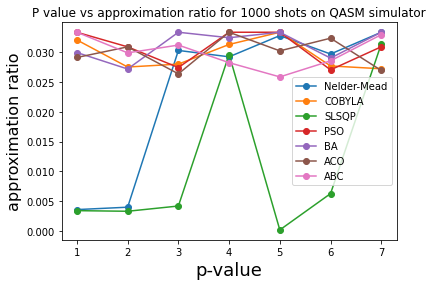

gradient_values_nm=[0.030700000000000015, 0.04950000000000001, 0.14699999999999996, 0.1566, 0.16666666666666666, 0.11646666666666669, 0.1691]
gradient_values_cobyla=[0.12943333333333332, 0.12596666666666664, 0.13786666666666667, 0.16249999999999998, 0.16369999999999998, 0.16746666666666662, 0.17190000000000003]
gradient_values_slsqp=[0.029233333333333347, 0.039733333333333336, 0.03166666666666668, 0.10766666666666672, 0.0006666666666666669, 0.05706666666666668, 0.13676666666666665]
swarm_values=[0.1138, 0.16493333333333332, 0.14616666666666667, 0.15456666666666666, 0.16219999999999998, 0.16473333333333334, 0.1672]
bats_values=[0.13359999999999997, 0.16083333333333333, 0.16729999999999998, 0.16763333333333336, 0.16119999999999995, 0.16373333333333331, 0.1693666666666667]
ants_values=[0.12086666666666669, 0.15599999999999997, 0.15786666666666663, 0.14903333333333332, 0.15916666666666662, 0.15359999999999993, 0.15286666666666662]
bees_values=[0.12416666666666666, 0.1607666666666666, 0.146

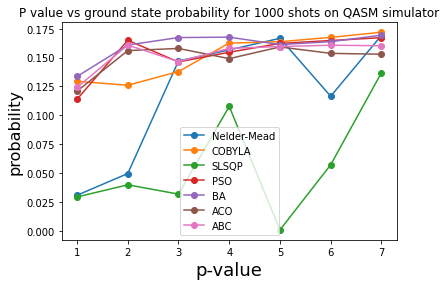

gradient_time_nm=[11.782992124557495, 31.908735752105713, 60.30841326713562, 96.81301736831665, 159.79647755622864, 216.50348925590515, 258.20539140701294]
gradient_time_cobyla=[0.7870986461639404, 2.1525232791900635, 3.1948766708374023, 5.79361891746521, 9.75716519355774, 11.073196649551392, 14.529476404190063]
gradient_time_slsqp=[3.6981685161590576, 10.373546600341797, 29.12727403640747, 47.1350154876709, 24.329386234283447, 100.32431483268738, 155.83904099464417]
swarm_time=[27.669748067855835, 40.45091891288757, 58.53038001060486, 61.44648265838623, 80.27027702331543, 83.32768487930298, 85.19134902954102]
bats_time=[84.46079301834106, 115.70972895622253, 153.15751767158508, 180.49013113975525, 230.44925141334534, 226.50472903251648, 242.26870274543762]
ants_time=[36.06187844276428, 52.86052656173706, 71.72321605682373, 80.17406916618347, 105.36136436462402, 113.01910042762756, 111.46141743659973]
bees_time=[64.2370195388794, 93.1651782989502, 128.39006400108337, 159.9618284702301,

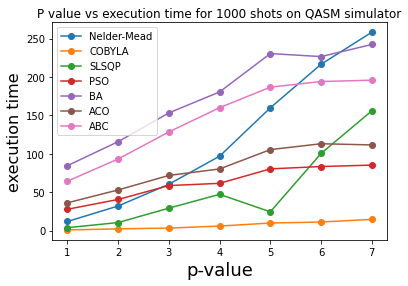

In [16]:
test_n_nodes(4,'0011', G) 

# 5 nodes graph

00011 6


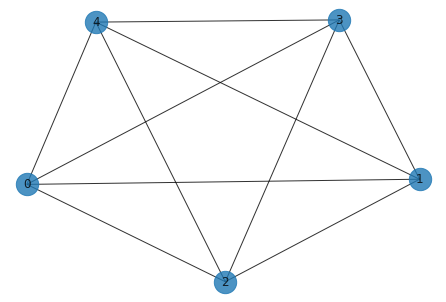

In [17]:
G = get_objective(5)

[0.25 0.25]
[0.25 0.25]
[0.25 0.25]
iteration 0 with cost of -5.8046875
[0.25 0.25]
[0.25 0.25]
[0.125 0.375 0.375 0.125]
[0.125 0.375 0.375 0.125]
[0.125 0.375 0.375 0.125]
iteration 0 with cost of -5.92578125
[0.125 0.375 0.375 0.125]
[0.125 0.375 0.375 0.125]
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
iteration 0 with cost of -4.73828125
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
iteration 0 with cost of -4.921875
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
[0.05 0.45 0.15 0.35 0.25 0.25 0.35

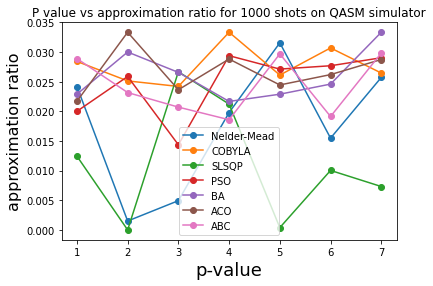

gradient_values_nm=[0.04186666666666667, 0.01203333333333334, 0.026166666666666682, 0.05163333333333334, 0.04393333333333334, 0.025900000000000017, 0.051066666666666684]
gradient_values_cobyla=[0.04896666666666668, 0.0478, 0.050466666666666674, 0.053200000000000004, 0.05046666666666667, 0.05313333333333334, 0.0514]
gradient_values_slsqp=[0.025400000000000013, 0.0001, 0.03983333333333334, 0.03290000000000001, 0.003566666666666668, 0.02433333333333335, 0.02160000000000001]
swarm_values=[0.0483, 0.04933333333333333, 0.04823333333333335, 0.04970000000000001, 0.05056666666666667, 0.04933333333333335, 0.05183333333333335]
bats_values=[0.05016666666666668, 0.049066666666666675, 0.049900000000000014, 0.05183333333333333, 0.04670000000000001, 0.049233333333333344, 0.048333333333333346]
ants_values=[0.04990000000000002, 0.049566666666666676, 0.044433333333333346, 0.048200000000000014, 0.04973333333333333, 0.04496666666666668, 0.04523333333333335]
bees_values=[0.05006666666666668, 0.0507666666666

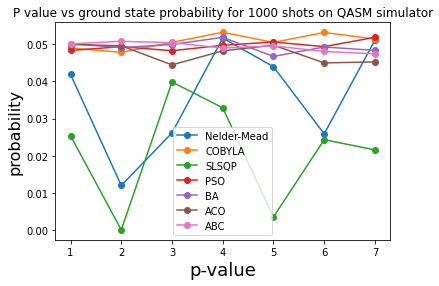

gradient_time_nm=[13.097686529159546, 34.980820417404175, 72.1924831867218, 26.10764193534851, 195.58059310913086, 213.85617780685425, 281.9657344818115]
gradient_time_cobyla=[1.0882599353790283, 2.0071771144866943, 4.566974878311157, 7.329298973083496, 10.363442420959473, 10.298091173171997, 14.362833023071289]
gradient_time_slsqp=[3.8422470092773438, 13.45992636680603, 37.05613136291504, 45.69572830200195, 98.88054513931274, 80.12397766113281, 170.25734496116638]
swarm_time=[32.61658024787903, 54.887460231781006, 69.63116002082825, 82.24361896514893, 79.06901407241821, 90.47352433204651, 101.81731009483337]
bats_time=[92.63276219367981, 128.88470196723938, 197.64916944503784, 243.72186398506165, 223.60842490196228, 261.7743020057678, 290.94296383857727]
ants_time=[42.52874779701233, 71.61186265945435, 91.09022331237793, 109.59695839881897, 104.13731360435486, 118.61820673942566, 133.61544132232666]
bees_time=[74.95199179649353, 125.38946008682251, 161.30903673171997, 188.244492053985

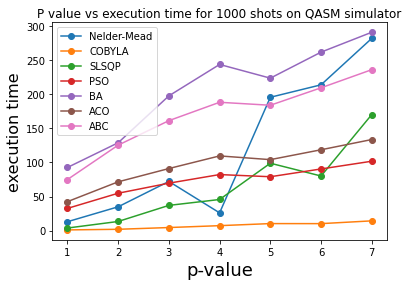

In [18]:
test_n_nodes(5,'00011', G)

# 6 nodes graph

000111 9


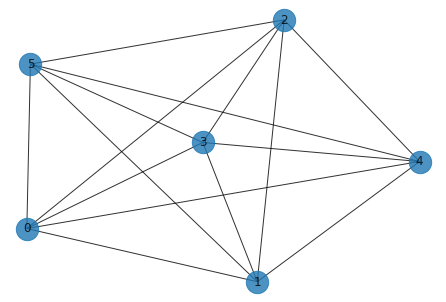

In [8]:
G = get_objective(6)

[0.25 0.25]
[0.25 0.25]
[0.25 0.25]
iteration 0 with cost of -8.3369140625
[0.25 0.25]
[0.25 0.25]
[0.125 0.375 0.375 0.125]
[0.125 0.375 0.375 0.125]
[0.125 0.375 0.375 0.125]
iteration 0 with cost of -7.986328125
[0.125 0.375 0.375 0.125]
[0.125 0.375 0.375 0.125]
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
iteration 0 with cost of -8.1708984375
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
iteration 0 with cost of -8.0126953125
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
[0.05 0.45 0.15 0.35 0.25

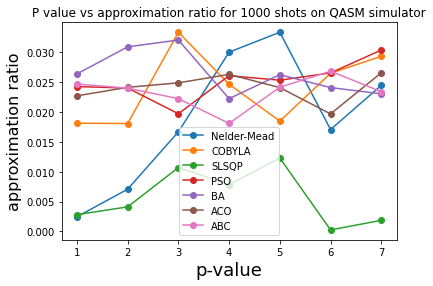

gradient_values_nm=[0.006200000000000002, 0.011200000000000007, 0.01773333333333334, 0.05076666666666667, 0.016966666666666675, 0.03220000000000001, 0.01876666666666667]
gradient_values_cobyla=[0.032833333333333346, 0.03756666666666667, 0.049633333333333335, 0.037633333333333345, 0.04853333333333335, 0.05256666666666668, 0.05026666666666667]
gradient_values_slsqp=[0.005066666666666669, 0.007233333333333336, 0.014433333333333338, 0.03476666666666668, 0.02053333333333334, 0.0013666666666666673, 0.012233333333333339]
swarm_values=[0.034000000000000016, 0.03780000000000001, 0.032000000000000015, 0.04286666666666668, 0.03966666666666667, 0.03656666666666668, 0.046733333333333335]
bats_values=[0.031800000000000016, 0.03410000000000001, 0.04276666666666668, 0.041066666666666675, 0.046866666666666675, 0.0456, 0.04296666666666668]
ants_values=[0.03396666666666669, 0.035366666666666685, 0.047833333333333346, 0.038900000000000004, 0.03883333333333334, 0.04746666666666668, 0.04890000000000001]
bee

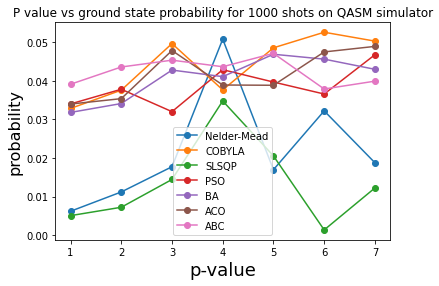

gradient_time_nm=[17.377000093460083, 45.6136953830719, 94.46258759498596, 131.071293592453, 185.07807803153992, 270.0453405380249, 354.75559258461]
gradient_time_cobyla=[1.189751148223877, 2.727081060409546, 5.565725326538086, 6.771528959274292, 9.54918909072876, 15.847170352935791, 17.255334615707397]
gradient_time_slsqp=[6.192373991012573, 22.211681365966797, 40.511740922927856, 59.89745092391968, 79.89724469184875, 164.00851488113403, 194.69434309005737]
swarm_time=[41.78101944923401, 58.236867904663086, 73.16395902633667, 83.01315665245056, 105.01415395736694, 114.02182340621948, 132.37804532051086]
bats_time=[118.54140877723694, 163.172221660614, 210.18079733848572, 233.95406484603882, 271.0491416454315, 320.0751373767853, 393.96354603767395]
ants_time=[54.39197659492493, 75.24271512031555, 96.23708605766296, 110.14965438842773, 130.22780990600586, 144.13700437545776, 185.03118467330933]
bees_time=[96.10899949073792, 128.6648874282837, 164.48049807548523, 188.2503318786621, 238.3

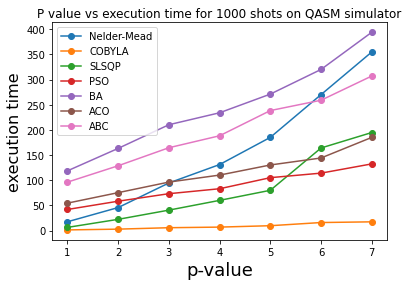

In [12]:
test_n_nodes(6,'000111', G)

# 7 nodes graph

0000111 12


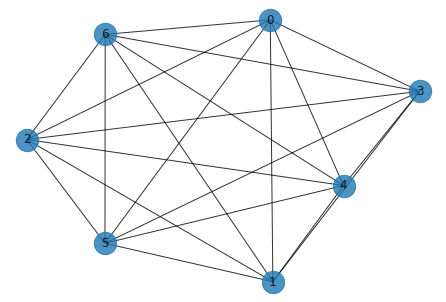

In [19]:
G = get_objective(7)

[0.25 0.25]
[0.25 0.25]
[0.25 0.25]
iteration 0 with cost of -11.78125
[0.25 0.25]
[0.25 0.25]
[0.125 0.375 0.375 0.125]
[0.125 0.375 0.375 0.125]
[0.125 0.375 0.375 0.125]
iteration 0 with cost of -11.142578125
[0.125 0.375 0.375 0.125]
[0.125 0.375 0.375 0.125]
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
iteration 0 with cost of -9.0859375
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
iteration 0 with cost of -10.064453125
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
[0.05 0.45 0.15 0.35 0.25 0.25 

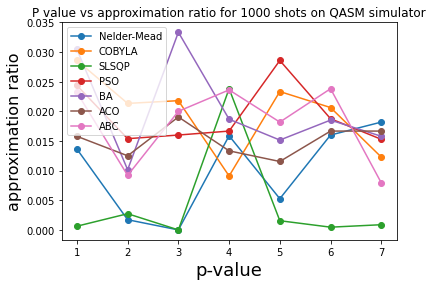

gradient_values_nm=[0.011700000000000007, 0.006700000000000002, 0.0009000000000000002, 0.011600000000000006, 0.006800000000000003, 0.014333333333333342, 0.013900000000000006]
gradient_values_cobyla=[0.014200000000000006, 0.013866666666666673, 0.014600000000000009, 0.013733333333333339, 0.010833333333333339, 0.01016666666666667, 0.012566666666666672]
gradient_values_slsqp=[0.003333333333333334, 0.004466666666666669, 0.0014666666666666671, 0.010266666666666672, 0.0021000000000000007, 0.0013333333333333337, 0.00043333333333333337]
swarm_values=[0.015333333333333341, 0.014500000000000006, 0.012466666666666673, 0.014300000000000007, 0.013700000000000002, 0.010033333333333339, 0.01303333333333334]
bats_values=[0.014000000000000007, 0.01423333333333334, 0.013000000000000008, 0.013500000000000005, 0.01263333333333334, 0.01123333333333334, 0.012833333333333337]
ants_values=[0.013833333333333336, 0.01293333333333334, 0.013333333333333338, 0.01253333333333334, 0.01123333333333334, 0.0133333333333

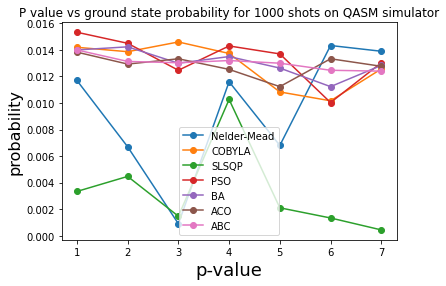

gradient_time_nm=[16.891479969024658, 46.96983218193054, 90.42404770851135, 147.8520622253418, 253.08903527259827, 314.80112767219543, 402.4062457084656]
gradient_time_cobyla=[1.1859910488128662, 3.0828139781951904, 5.52893853187561, 7.9843950271606445, 11.834432601928711, 15.325417280197144, 20.69534683227539]
gradient_time_slsqp=[7.840066432952881, 16.95799207687378, 47.49460816383362, 65.5124123096466, 138.2374930381775, 60.92755055427551, 210.72378706932068]
swarm_time=[42.90738892555237, 59.84723424911499, 76.13334369659424, 104.159747838974, 117.60634422302246, 130.94445061683655, 157.91888642311096]
bats_time=[121.57523846626282, 170.67607879638672, 218.54229497909546, 277.22615599632263, 317.55605697631836, 385.26089096069336, 469.1258022785187]
ants_time=[55.78622555732727, 78.36998009681702, 100.36703538894653, 140.48552083969116, 145.93360209465027, 182.09759497642517, 196.8813281059265]
bees_time=[99.08725166320801, 138.6944215297699, 180.2639536857605, 246.19437789916992, 

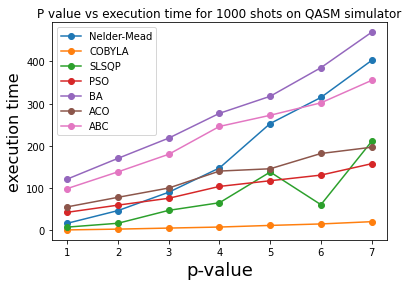

In [20]:
test_n_nodes(7,'0000111', G)

# 8 nodes graph

00001111 16


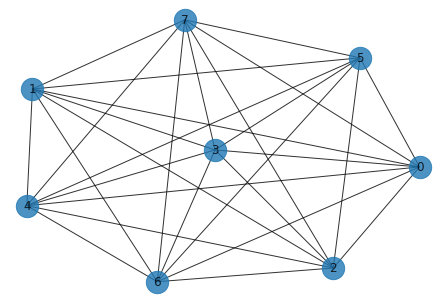

In [5]:
G = get_objective(8)

[0.25 0.25]
[0.25 0.25]
[0.25 0.25]
iteration 0 with cost of -13.8203125
[0.25 0.25]
[0.25 0.25]
[0.125 0.375 0.375 0.125]
[0.125 0.375 0.375 0.125]
[0.125 0.375 0.375 0.125]
iteration 0 with cost of -15.4775390625
[0.125 0.375 0.375 0.125]
[0.125 0.375 0.375 0.125]
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
iteration 0 with cost of -13.5703125
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
iteration 0 with cost of -13.029296875
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
[0.05 0.45 0.15 0.35 0.25 0

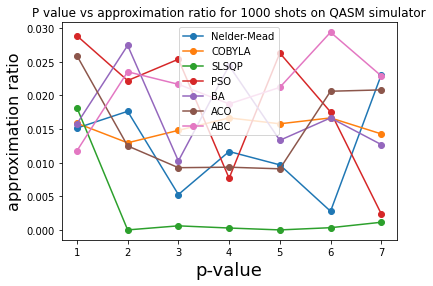

gradient_values_nm=[0.005933333333333336, 0.009433333333333339, 0.0041666666666666675, 0.008833333333333337, 0.009833333333333338, 0.0015666666666666676, 0.006533333333333336]
gradient_values_cobyla=[0.008033333333333337, 0.00956666666666667, 0.010033333333333339, 0.013366666666666674, 0.01166666666666667, 0.010866666666666672, 0.013233333333333338]
gradient_values_slsqp=[0.0052000000000000015, 0.0004666666666666667, 0.002033333333333334, 0.0011, 0.00016666666666666666, 0.0017666666666666673, 0.005400000000000003]
swarm_values=[0.010166666666666673, 0.008800000000000004, 0.011366666666666672, 0.003233333333333335, 0.011066666666666673, 0.010100000000000005, 0.0034000000000000015]
bats_values=[0.008233333333333337, 0.011133333333333337, 0.005966666666666668, 0.008300000000000004, 0.01323333333333334, 0.007066666666666669, 0.011233333333333336]
ants_values=[0.009233333333333336, 0.007233333333333336, 0.01036666666666667, 0.004466666666666669, 0.010633333333333337, 0.010033333333333339, 0

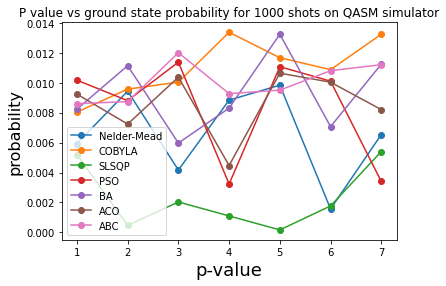

gradient_time_nm=[20.774566173553467, 51.09265208244324, 110.6238522529602, 162.1018831729889, 251.54508709907532, 334.1341233253479, 442.4892387390137]
gradient_time_cobyla=[1.4450864791870117, 3.2157576084136963, 5.7499024868011475, 10.14118766784668, 11.746544122695923, 15.04260778427124, 24.250198125839233]
gradient_time_slsqp=[9.313861846923828, 23.020346641540527, 54.824514865875244, 70.07049441337585, 87.48444652557373, 177.61292695999146, 272.636323928833]
swarm_time=[46.76284861564636, 66.50839614868164, 94.32516074180603, 114.8722722530365, 121.34248614311218, 141.0640459060669, 161.66922879219055]
bats_time=[134.76689767837524, 186.51598167419434, 266.2622787952423, 288.94881105422974, 340.5739572048187, 403.7866644859314, 457.9218134880066]
ants_time=[61.76823711395264, 84.30403780937195, 121.8239517211914, 148.02352905273438, 158.30008697509766, 183.903968334198, 211.9229691028595]
bees_time=[108.32155323028564, 167.94221258163452, 193.7147662639618, 266.2371349334717, 281

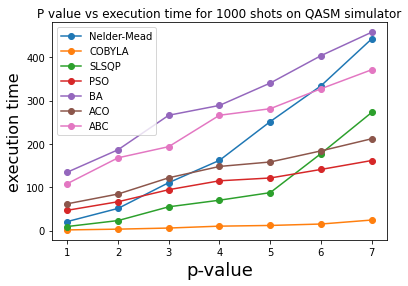

In [6]:
test_n_nodes(8,'00001111', G)

# 9 nodes graph

000001111 20


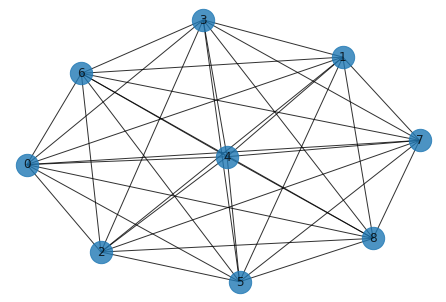

In [5]:
G = get_objective(9)

[0.25 0.25]
[0.25 0.25]
[0.25 0.25]
iteration 0 with cost of -19.8203125
[0.25 0.25]
[0.25 0.25]
[0.125 0.375 0.375 0.125]
[0.125 0.375 0.375 0.125]
[0.125 0.375 0.375 0.125]
iteration 0 with cost of -19.27734375
[0.125 0.375 0.375 0.125]
[0.125 0.375 0.375 0.125]
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
iteration 0 with cost of -13.853515625
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
iteration 0 with cost of -16.83984375
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
[0.05 0.45 0.15 0.35 0.25 0.

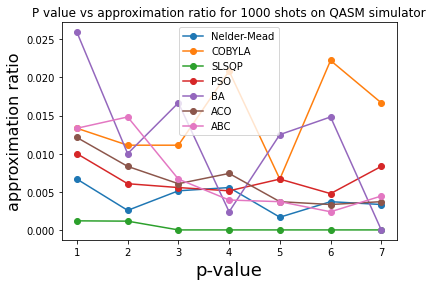

gradient_values_nm=[0.0023000000000000013, 0.0012000000000000003, 0.0011000000000000003, 0.0017333333333333341, 0.004133333333333335, 0.0013000000000000004, 0.002233333333333334]
gradient_values_cobyla=[0.004033333333333336, 0.0042000000000000015, 0.004133333333333335, 0.0023666666666666675, 0.003066666666666668, 0.003566666666666668, 0.001733333333333334]
gradient_values_slsqp=[0.0012000000000000003, 0.0006333333333333336, 0.0005666666666666668, 0.0015333333333333338, 6.666666666666667e-05, 0.0010333333333333338, 0.0005000000000000001]
swarm_values=[0.003833333333333335, 0.003333333333333334, 0.004033333333333334, 0.0034333333333333347, 0.001733333333333334, 0.003133333333333335, 0.002766666666666668]
bats_values=[0.0035000000000000014, 0.0039000000000000016, 0.0033000000000000013, 0.003600000000000001, 0.0026666666666666674, 0.0027333333333333346, 0.0021333333333333343]
ants_values=[0.004166666666666668, 0.0035000000000000014, 0.004166666666666668, 0.0016000000000000003, 0.0012666666

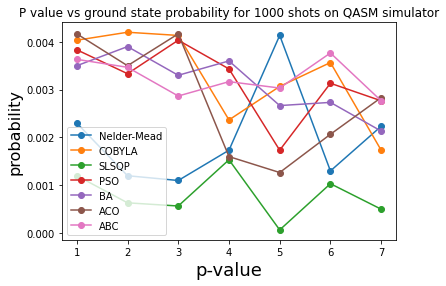

gradient_time_nm=[25.232849836349487, 62.45313286781311, 156.76356625556946, 228.88505721092224, 299.2842125892639, 399.86047291755676, 547.8493509292603]
gradient_time_cobyla=[1.9474353790283203, 4.303077936172485, 8.227951765060425, 10.691437005996704, 15.458088636398315, 17.85810661315918, 28.679898738861084]
gradient_time_slsqp=[8.663615465164185, 25.764490127563477, 74.06349301338196, 104.06374597549438, 49.76357889175415, 226.19838404655457, 356.40172147750854]
swarm_time=[66.01586365699768, 102.54327821731567, 131.5220241546631, 133.02026891708374, 147.44194984436035, 169.44976663589478, 195.2095422744751]
bats_time=[166.98949217796326, 233.01710152626038, 378.4343247413635, 369.42095828056335, 418.59576177597046, 470.73895168304443, 616.8526537418365]
ants_time=[80.35453987121582, 107.13057017326355, 171.56850790977478, 176.00510501861572, 191.0977919101715, 219.37103486061096, 264.2163188457489]
bees_time=[127.94514918327332, 243.30903148651123, 303.5174219608307, 300.55253577

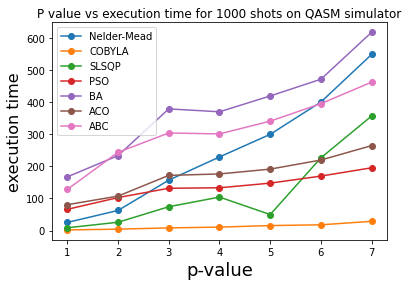

In [6]:
test_n_nodes(9,'000001111', G)